# Prompt selection and testing

This notebook chooses the most appropriate prompt and prompt structure for the OCR correction. 

In [58]:
#import config  # Import your config.py file this contains you openai api key
import pandas as pd
import numpy as np
import os
from llm_comparison_toolkit import RateLimiter, get_response_openai, get_response_anthropic,  create_config_dict_func, compare_request_configurations
from evaluate import load
from evaluation_funcs import evaluate_correction_performance, evaluate_correction_performance_folders, get_metric_error_reduction
from helper_functions import files_to_df_func, files_to_df_core_func
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv
load_dotenv()
save_appendix = os.getenv("save_appendix")

dev_data_folder = 'data/dev_data'
dev_transcripts = os.path.join(dev_data_folder, 'dev_data_transcript')
dev_raw_ocr_folder =  os.path.join(dev_data_folder,'dev_raw_ocr' )
dev_system_message_folder = os.path.join(dev_data_folder,'dev_system_message_variants' )

#load the dev and test sets for prompt development and selection
dev_data_df = pd.read_csv(os.path.join(dev_data_folder,'dev_data_raw.csv'))


#for saving data to be used in the analysis
if not os.path.exists('data/analysis'):
    os.makedirs('data/analysis')

# Explore different system prompts

This explores a range of system prompt to find the one that appears to work the best, we use gpt4 as the baseline model.

Although there is no comparison with all models we do test gpt3.5 gpt4, clause haiku and claude opus, in addition we put the prompt in the system message and the prompt after the text becuase this may affect the quality of the result. When the prompt is after the text the response has "nosm_" (no system message) appended to the file name

In [2]:
#Create a modular set of system messages that can be combined in different ways
basic_prompt = "Please recover the text from the corrupted OCR."
expertise_prompt = "You are an expert in post-OCR correction of documents."
recover_prompt = "Using the context available from the text please recover the most likely original text from the corrupted OCR."
publication_context_prompt = "The text is from an english newspaper in the 1800's."
text_context_prompt = "The text may be an advert or article and may be missing the beggining or end."
additional_instructions_prompt = "Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."

#combine all the message parts into a variety of system messages, a tuple is used where 0 is the name of the message and 1 is the message itself
#N.B. This is not and exhaustive combination as that would be very expensive and likley not yield significantly better results
system_messages_list = [
('basic_prompt', basic_prompt),
('expert_basic_prompt', expertise_prompt + ' '+ basic_prompt),
('expert_recover_prompt', expertise_prompt + ' '+ recover_prompt),
('expert_recover_publication_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + publication_context_prompt),
('expert_recover_text_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + text_context_prompt),
('expert_recover_publication_text_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + publication_context_prompt + ' ' + text_context_prompt),
('expert_recover_instructions_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + additional_instructions_prompt),
('full_context_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + publication_context_prompt + ' ' + text_context_prompt+ ' ' + additional_instructions_prompt)
]

The below function is used to make the creation of the config dictionaries for the test more compact and increase readability

In [3]:
def create_message_test_configs(system_messages_list, get_response_func, engine):
    message_test_configs = []
    for iter_system_message in system_messages_list:
        message_test_configs.append(
            create_config_dict_func(
                get_response_func=get_response_func,
                rate_limiter=RateLimiter(50000),
                engine=engine,
                system_message_template=iter_system_message[1],
                prompt_template="{content_html}",
                additional_args={'response_name': iter_system_message[0]}
            )
        )
        message_test_configs.append(
            create_config_dict_func(
                get_response_func=get_response_func,
                rate_limiter=RateLimiter(50000),
                engine=engine,
                system_message_template="",
                prompt_template="{content_html}" + f"""\n\n""" + iter_system_message[1],
                additional_args={'response_name': "nosm_"+iter_system_message[0]}
            )
        )
    return message_test_configs

## Create configs and run tests

In [4]:
#gpt configs
gpt3_prompt_testing_configs = create_message_test_configs(system_messages_list, get_response_openai, "gpt-3.5-turbo")
gpt4_prompt_testing_configs = create_message_test_configs(system_messages_list, get_response_openai, 'gpt-4-turbo-preview')

#claude configs
haiku_prompt_testing_configs = create_message_test_configs(system_messages_list, get_response_anthropic, "claude-3-haiku-20240307")
opus_prompt_testing_configs = create_message_test_configs(system_messages_list, get_response_anthropic, "claude-3-opus-20240229")

#run the experiment on all the prompt configs and save to the folder
compare_request_configurations(dev_data_df, 
                               gpt3_prompt_testing_configs + gpt4_prompt_testing_configs + haiku_prompt_testing_configs + opus_prompt_testing_configs,
                               folder_path = dev_system_message_folder )

In [5]:

prompt_test_df = []
for folder in os.listdir(dev_system_message_folder):
    df = files_to_df_core_func(dev_system_message_folder)
    df['folder'] = folder
    prompt_test_df.append(df)

prompt_test_df = pd.concat(prompt_test_df, ignore_index=True)

# Evaluate system prompt tests

We evaluate the system prompts below to see if thre is any significant difference between the prompts


In [6]:
wer = load("wer")
cer = load("cer")

In [7]:
raw_dev_ocr_scores = evaluate_correction_performance(dev_raw_ocr_folder , dev_transcripts, wer, cer, 'raw_ocr')

In [8]:
corrected_folder = dev_system_message_folder

performance_eval = evaluate_correction_performance_folders(corrected_folder, dev_transcripts, wer, cer)

performance_eval =  performance_eval.loc[(performance_eval['File Name']!='slug_ar02501_periodical_pc_issue_tec_06121884_page_number_25.txt'),:]

performance_eval['type'] = performance_eval['type'].str.replace("claude-3-haiku-20240307", "haiku").replace("gpt-3.5-turbo", "gpt-3.5")

performance_eval['model'] = performance_eval['type'].str.split('_').str[-1]

In [9]:
test = get_metric_error_reduction(performance_eval, raw_dev_ocr_scores)

In [10]:
test.groupby('type').describe().filter(regex = '50|mean').round(2).sort_values(('lev_dist', '50%'))

WER            CER  \
                                                     mean    50%    mean   
type                                                                       
expert_recover_text_prompt_haiku                    -4.66   8.18 -296.51   
nosm_expert_recover_publication_text_prompt_haiku    2.83  12.73 -294.84   
expert_recover_publication_text_prompt_haiku        16.26  31.82 -209.72   
nosm_expert_recover_text_prompt_haiku                0.41   7.50 -297.10   
expert_recover_prompt_haiku                         37.93  45.61  -90.47   
...                                                   ...    ...     ...   
nosm_full_context_prompt_gpt-4-turbo-preview        73.21  77.19   54.38   
nosm_expert_recover_pub_instructions_prompt_cla...  71.88  78.71   40.15   
nosm_full_context_prompt_claude-3-opus-20240229     72.74  80.46   58.40   
expert_recover_instructions_prompt_claude-3-opu...  72.91  81.03   46.22   
nosm_expert_recover_prompt_gpt-4-turbo-preview      72.10  75.86   49.29   

                                                           lev_dist          
                                                       50%     mean     50%  
type                                                                         
expert_recover_text_prompt_haiku                   -197.56  -283.62 -181.11  
nosm_expert_recover_publication_text_prompt_haiku  -152.04  -281.51 -147.84  
expert_recover_publication_text_prompt_haiku       -115.22  -200.48 -110.20  
nosm_expert_recover_text_prompt_haiku              -106.33  -283.08 -103.45  
expert_recover_prompt_haiku                         -38.91   -86.93  -40.09  
...                                                    ...      ...     ...  
nosm_full_context_prompt_gpt-4-turbo-preview         63.78    51.48   62.23  
nosm_expert_recover_pub_instructions_prompt_cla...   68.74    37.37   62.84  
nosm_full_context_prompt_claude-3-opus-20240229      68.74    54.51   62.84  
expert_recover_instructions_prompt_claude-3-opu...   65.41    42.21   63.30  
nosm_expert_recover_prompt_gpt-4-turbo-preview       65.55    46.21   63.79  

[72 rows x 6 columns]

In [11]:
test.loc[test['type'].str.contains('opus')].groupby('type').describe().filter(regex = '50|mean').round(2).sort_values(('lev_dist', '50%'))

WER           CER  \
                                                     mean    50%   mean   
type                                                                      
nosm_expert_recover_publication_text_prompt_cla...  55.27  74.37 -30.47   
nosm_expert_recover_publication_prompt_claude-3...  71.07  73.90  44.04   
nosm_expert_recover_text_prompt_claude-3-opus-2...  70.36  76.02  49.85   
nosm_basic_prompt_claude-3-opus-20240229            69.83  72.41  46.73   
nosm_expert_recover_prompt_claude-3-opus-20240229   72.06  76.88  48.80   
expert_recover_prompt_claude-3-opus-20240229        62.40  73.90   4.22   
expert_recover_pub_instructions_prompt_claude-3...  74.58  78.89  57.67   
expert_recover_publication_prompt_claude-3-opus...  70.00  74.37  41.13   
expert_recover_text_prompt_claude-3-opus-20240229   71.19  72.41  43.40   
expert_recover_publication_text_prompt_claude-3...  69.84  74.14  41.57   
full_context_prompt_claude-3-opus-20240229          67.83  78.89  24.82   
basic_prompt_claude-3-opus-20240229                 71.42  75.86  41.21   
nosm_expert_basic_prompt_claude-3-opus-20240229     72.86  77.59  55.84   
expert_basic_prompt_claude-3-opus-20240229          75.14  79.57  58.65   
nosm_expert_recover_instructions_prompt_claude-...  73.45  81.03  55.15   
nosm_expert_recover_pub_instructions_prompt_cla...  71.88  78.71  40.15   
nosm_full_context_prompt_claude-3-opus-20240229     72.74  80.46  58.40   
expert_recover_instructions_prompt_claude-3-opu...  72.91  81.03  46.22   

                                                          lev_dist         
                                                      50%     mean    50%  
type                                                                       
nosm_expert_recover_publication_text_prompt_cla...  43.74   -33.26  40.25  
nosm_expert_recover_publication_prompt_claude-3...  50.23    39.63  45.26  
nosm_expert_recover_text_prompt_claude-3-opus-2...  57.28    45.44  46.78  
nosm_basic_prompt_claude-3-opus-20240229            52.74    42.14  47.06  
nosm_expert_recover_prompt_claude-3-opus-20240229   53.71    44.31  51.41  
expert_recover_prompt_claude-3-opus-20240229        56.11     2.23  51.65  
expert_recover_pub_instructions_prompt_claude-3...  66.22    52.95  51.72  
expert_recover_publication_prompt_claude-3-opus...  55.14    36.57  51.72  
expert_recover_text_prompt_claude-3-opus-20240229   56.22    38.97  51.72  
expert_recover_publication_text_prompt_claude-3...  57.01    37.36  53.19  
full_context_prompt_claude-3-opus-20240229          56.56    22.79  53.29  
basic_prompt_claude-3-opus-20240229                 57.01    37.20  53.62  
nosm_expert_basic_prompt_claude-3-opus-20240229     61.46    50.93  56.68  
expert_basic_prompt_claude-3-opus-20240229          64.39    53.70  59.45  
nosm_expert_recover_instructions_prompt_claude-...  66.83    50.36  61.12  
nosm_expert_recover_pub_instructions_prompt_cla...  68.74    37.37  62.84  
nosm_full_context_prompt_claude-3-opus-20240229     68.74    54.51  62.84  
expert_recover_instructions_prompt_claude-3-opu...  65.41    42.21  63.30

In [17]:
performance_eval2 = performance_eval.copy()
performance_eval2['type'] = performance_eval2['type'].str.replace("claude-3-haiku-20240307", "haiku").replace("gpt-3.5-turbo", "gpt-3.5")
performance_eval2['model'] = performance_eval2['type'].str.split('_').str[-1]
#performance_eval2 = performance_eval2.loc[performance_eval2['model'].str.contains('gpt-4')]
performance_eval2.drop(columns = 'File Name').groupby(['type', 'model']).describe().filter(regex = '50|mean').round(2).sort_values(('lev_dist', '50%'))

WER  \
                                                                           mean   
type                                               model                          
nosm_expert_recover_instructions_prompt_gpt-4-t... gpt-4-turbo-preview     0.23   
full_context_prompt_gpt-4-turbo-preview            gpt-4-turbo-preview     0.23   
expert_recover_pub_instructions_prompt_gpt-4-tu... gpt-4-turbo-preview     0.23   
expert_recover_instructions_prompt_claude-3-opu... claude-3-opus-20240229  0.24   
nosm_full_context_prompt_gpt-4-turbo-preview       gpt-4-turbo-preview     0.24   
...                                                                         ...   
nosm_expert_recover_publication_prompt_haiku       haiku                   0.59   
expert_recover_publication_text_prompt_haiku       haiku                   0.72   
expert_recover_text_prompt_haiku                   haiku                   0.84   
nosm_expert_recover_text_prompt_haiku              haiku                   0.82   
nosm_expert_recover_publication_text_prompt_haiku  haiku                   0.82   

                                                                                 \
                                                                            50%   
type                                               model                          
nosm_expert_recover_instructions_prompt_gpt-4-t... gpt-4-turbo-preview     0.15   
full_context_prompt_gpt-4-turbo-preview            gpt-4-turbo-preview     0.13   
expert_recover_pub_instructions_prompt_gpt-4-tu... gpt-4-turbo-preview     0.14   
expert_recover_instructions_prompt_claude-3-opu... claude-3-opus-20240229  0.19   
nosm_full_context_prompt_gpt-4-turbo-preview       gpt-4-turbo-preview     0.16   
...                                                                         ...   
nosm_expert_recover_publication_prompt_haiku       haiku                   0.53   
expert_recover_publication_text_prompt_haiku       haiku                   0.51   
expert_recover_text_prompt_haiku                   haiku                   0.90   
nosm_expert_recover_text_prompt_haiku              haiku                   0.81   
nosm_expert_recover_publication_text_prompt_haiku  haiku                   0.68   

                                                                            CER  \
                                                                           mean   
type                                               model                          
nosm_expert_recover_instructions_prompt_gpt-4-t... gpt-4-turbo-preview     0.13   
full_context_prompt_gpt-4-turbo-preview            gpt-4-turbo-preview     0.13   
expert_recover_pub_instructions_prompt_gpt-4-tu... gpt-4-turbo-preview     0.13   
expert_recover_instructions_prompt_claude-3-opu... claude-3-opus-20240229  0.14   
nosm_full_context_prompt_gpt-4-turbo-preview       gpt-4-turbo-preview     0.14   
...                                                                         ...   
nosm_expert_recover_publication_prompt_haiku       haiku                   0.44   
expert_recover_publication_text_prompt_haiku       haiku                   0.58   
expert_recover_text_prompt_haiku                   haiku                   0.68   
nosm_expert_recover_text_prompt_haiku              haiku                   0.64   
nosm_expert_recover_publication_text_prompt_haiku  haiku                   0.66   

                                                                                 \
                                                                            50%   
type                                               model                          
nosm_expert_recover_instructions_prompt_gpt-4-t... gpt-4-turbo-preview     0.06   
full_context_prompt_gpt-4-turbo-preview            gpt-4-turbo-preview     0.06   
expert_recover_pub_instructions_prompt_gpt-4-tu... gpt-4-turbo-preview     0.05   
expert_recover_instructions_prompt_claude-3-opu... claude-3-opus-20240229  0.05   
nosm_f

In [24]:
result = performance_eval2.drop(columns='File Name') \
    .groupby(['model', 'type'])['CER'] \
    .median() \
    .reset_index() \
    .sort_values('CER') \
    .groupby('model') \
    .head(2) \
    .set_index(['model', 'type']).sort_values('model')


#result['prompt'] = result['type'].str.split('_').str[0]
result

CER
model                  type                                                        
claude-3-opus-20240229 nosm_full_context_prompt_claude-3-opus-20240229     0.041680
                       expert_recover_instructions_prompt_claude-3-opu...  0.048680
gpt-3.5-turbo          expert_basic_prompt_gpt-3.5-turbo                   0.052180
                       expert_recover_publication_prompt_gpt-3.5-turbo     0.054725
gpt-4-turbo-preview    expert_recover_pub_instructions_prompt_gpt-4-tu...  0.045180
                       expert_recover_instructions_prompt_gpt-4-turbo-...  0.048680
haiku                  full_context_prompt_haiku                           0.093135
                       nosm_expert_basic_prompt_haiku                      0.093254

In [48]:
import matplotlib.ticker as ticker

/tmp/ipykernel_70231/532594401.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_70231/532594401.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


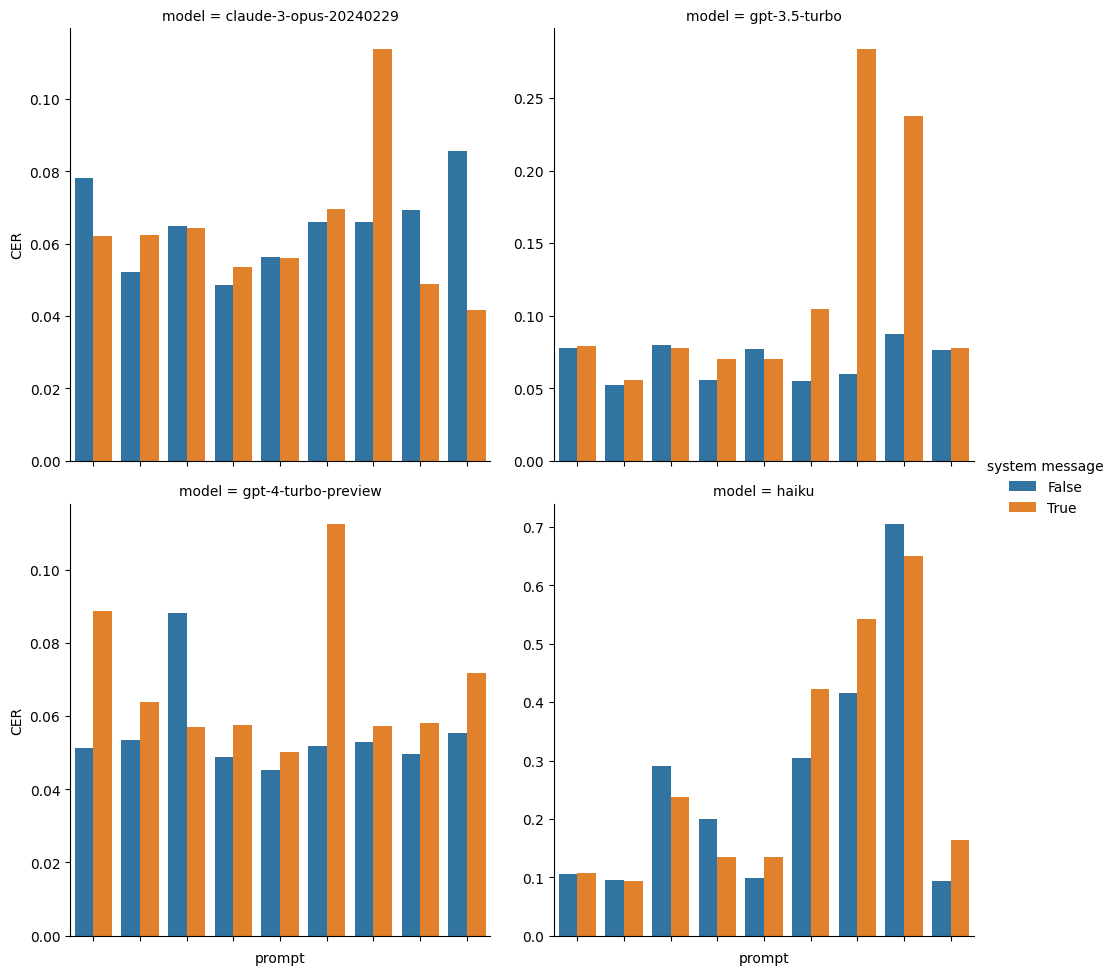

In [50]:
result = performance_eval2.drop(columns='File Name') \
    .groupby(['model', 'type'])['CER'] \
    .median() \
    .reset_index() 


result['prompt'] = result['type'].str.rsplit('_', n=2).str[0].str.replace("nosm_", "")
result['system message'] = np.where(result['type'].str.contains('nosm'), True, False)

result = result.sort_values(['prompt','system message'])

# Define the order in which 'prompt' categories should appear
#order = result['prompt'].unique()


g = sns.catplot(data=result, x='prompt', y='CER', hue='system message', kind='bar',  col='model', col_wrap= 2,  sharey=False)

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()


In [55]:
save_appendix

In [64]:
# Loop through each unique model and create a separate plot
for model in result['model'].unique():
    # Filter data for the current model
    print(model)
    model_data = result[result['model'] == model]
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=model_data, x='prompt', y='CER', hue='system message')
    
    # Set the title and labels
    plt.title(f'CER by Prompt Type for Model: {model}')
    plt.xlabel('Prompt')
    plt.ylabel('CER')
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    
    # Save the plot
    fig_filename = os.path.join(save_appendix, f"cer_{model.lower()}.png")
    plt.savefig(fig_filename)
    plt.close()  # Close the figure to free up memory

claude-3-opus-20240229
gpt-3.5-turbo
gpt-4-turbo-preview
haiku


## Conclusions of the prompt test

It appears that the placing the prompt after the text instead of using the system prompt gives the best results. However, the prompts did give significantlty different performance.  I think that perhaps using the `full_context_prompt` and the `expert_recover_publication_prompt` with no system message and the prompt after the text may be the best option. This will require twice as much compute as I was planning to use.

# Evaluating models on the test set

Having identified two different prompts and that the prompts appear to work better when places after the text we can now compare the different models


The below code creates the basic configuration dictionaries for each model and then fills in the with the two different prompt messages creating a single list of all basic prompt/model configurations. It then calls all the LLM's and saves the results.
This works in series so takes a while.

In [65]:
#There is no significant difference between nosm and sm so, who knows.

test2 = test.groupby('type')['lev_dist'].median().reset_index().copy()

test2['system_message'] = ~test2['type'].str.startswith('nosm')

test2['new_type'] = test2['type'].str.replace('nosm_', '', regex=True)

# Splitting data based on 'system_message'
data_true = test2[test2['system_message'] == True]
data_false = test2[test2['system_message'] == False]

# Merging on 'new_type'
merged_data = pd.merge(data_true, data_false, on='new_type', suffixes=('_true', '_false'))

# Bootstrap parameters
n_bootstrap = 10000
differences = []

for _ in range(n_bootstrap):
    # Resample the merged data with replacement
    sample = merged_data.sample(n=len(merged_data), replace=True)
    # Compute differences
    diff = sample['lev_dist_true'] - sample['lev_dist_false']
    # Calculate the median of these differences
    differences.append(diff.median())

# Calculate observed difference in medians from the original data
obs_diff = (merged_data['lev_dist_true'] - merged_data['lev_dist_false']).median()

# Estimate the p-value
p_value = np.mean(np.abs(differences) >= np.abs(obs_diff))

print("Observed median difference:", obs_diff)
print("P-Value from Bootstrap Test:", p_value)

Observed median difference: 1.7362332392678645
P-Value from Bootstrap Test: 0.5326
